In [1]:
# --- IMPORT ALL NECESSARY MODULES ---
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import random
import math
import copy
import numpy as np

In [2]:
# --- FUNCTION TO READ THE PROBLEM DATA ---
def read_vrp_file(path, filename):
    '''function for reading VRP instance file
    path = path
    filename = filename
    returns capacity (float), coordinates (dic), demand (dic)
    '''
    capacity = -1
    coordinates = {}
    demand = {}

    with open(path+filename, 'r') as file:
        current_section = None
        for line in file:
            line = line.strip()
            if line == '':
                continue
            if line.startswith("CAPACITY"):
                capacity_data = line.split()
                capacity = float(capacity_data[2])
            elif line == 'NODE_COORD_SECTION':
                current_section = 'coordinates'
            elif line == 'DEMAND_SECTION':
                current_section = 'demand'
            elif line == 'DEPOT_SECTION':
                current_section = 'depot'
            elif line == 'EOF':
                break                
            else:
                if current_section == 'coordinates':
                    node_data = line.split()
                    node_id = int(node_data[0])
                    x_coord = float(node_data[1])
                    y_coord = float(node_data[2])
                    coordinates[node_id] = (x_coord, y_coord)
                elif current_section == 'demand':
                    demand_data = line.split()
                    node_id = int(demand_data[0])
                    demand_value = int(demand_data[1])
                    demand[node_id] = demand_value

    return capacity, coordinates, demand


In [3]:
# --- FUNCTION TO GENERATE DISTANCE MATRIX ---
def create_VRP_distM(coordinates):
    '''function computing the distance matrix (using a function from scipy)
    euclidean_coordinates = euclidean coordinates (stored in a dictionary)
    '''
    positions = [coord for coord in coordinates.values()]
    distances = squareform(pdist(positions, 'euclidean'))
    return distances

In [4]:
def plot_vrp_graph(coordinates):
    '''function for plotting nodes
    coordinates = coordinates (stored in a dictionary)
    '''
    x_coords = [coord[0] for coord in coordinates.values()]
    y_coords = [coord[1] for coord in coordinates.values()]
    
    plt.figure(figsize=(8, 6))
    
    # Depot (demand=0)
    plt.scatter(x_coords[0], y_coords[0], color='orange', marker='s')
    # Customers (demand>0)
    plt.scatter(x_coords[1:], y_coords[1:], color='blue')
    plt.title('Locations')
    
    # Label nodes with index
    # for node, coord in coordinates.items():
        # plt.annotate(str(node), xy=coord, xytext=(5, 5), textcoords='offset points')
    
    plt.show()

In [5]:
# --- FUNCTION TO PLOT SOLUTIONS ---
def plot_vrp_graph_with_solution(coordinates, solution):
    '''Plot VRP nodes and routes.
    
    coordinates: dict {node_id: (x, y)}
    solution: dict {vehicle_id: [route_nodes]}
    '''
    x_coords = [coord[0] for coord in coordinates.values()]
    y_coords = [coord[1] for coord in coordinates.values()]
    
    plt.figure(figsize=(10, 8))
    
    # Plot depot (demand=0) as orange square
    plt.scatter(x_coords[0], y_coords[0], color='orange', marker='s', s=100, label='Depot')
    # Plot customers as blue circles
    plt.scatter(x_coords[1:], y_coords[1:], color='blue', s=50, label='Customers')
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Cycle colors if more vehicles
    
    # Plot each vehicle route
    for vehicle_id, route in solution.items():
        route_coords = np.array([coordinates[node] for node in route])
        plt.plot(route_coords[:, 0], route_coords[:, 1], color=colors[(vehicle_id-1) % len(colors)], 
                 label=f'Vehicle {vehicle_id}', linewidth=2)
        plt.scatter(route_coords[1:-1, 0], route_coords[1:-1, 1], color=colors[(vehicle_id-1) % len(colors)], s=70)
    
    plt.title('VRP Routes Visualization')
    plt.legend()
    plt.show()


In [6]:
# --- INITIAL DRAFT PRESENTED ON THE FIRST PRESENTATION ---
temperature = initial_temperature  # e.g., 1000
cooling_rate = 0.95
stopping_temperature = 1
max_iterations_per_temp = 100

# Construction of an initial feasible solution using Nearest Neighbor Heuristic
incumbent_solution = generate_initial_solution(distance_matrix, demand, capacity)
best_solution = incumbent_solution

while temperature > stopping_temperature:
    for iteration in 1 to max_iterations_per_temp:
        # Generate a random neighbor
        if random() < 0.5:
            new_solution = swap_customers(incumbent_solution)
        else:
            new_solution = two_opt_neighbor(incumbent_solution)
        
        # Check capacity constraint
        if capacity_check(new_solution, demand, capacity):
            new_cost = total_cost(new_solution, distance_matrix)
            current_cost = total_cost(incumbent_solution, distance_matrix)
            cost_diff = new_cost - current_cost

            # Acceptance criterion: better solutions or worse ones with some probability
            if cost_diff < 0 or random() < exp(-cost_diff / temperature):
                incumbent_solution = new_solution

                # Update best solution if better
                if new_cost < total_cost(best_solution, distance_matrix):
                    best_solution = new_solution

    # Decrease temperature
    temperature = temperature * cooling_rate

return best_solution

SyntaxError: invalid syntax (295556690.py, line 12)

In [7]:
# --- HELPER FUNCTIONS ---
def total_cost(solution, distances):
    """
    Calculates the total cost of a solution.

    Args:
        solution (dict): VRP solution.
        distances (np.array): Distance matrix.

    Returns:
        float: Total distance.
    """
    cost = 0
    for route in solution.values():
        for i in range(len(route) - 1):
            cost += distances[route[i] - 1, route[i + 1] - 1]
    return cost


def get_route_load(route, demand_dict):
    """
    Calculates the load of a route.

    Args:
        route (list): List of nodes.
        demand_dict (dict): Customer demands.

    Returns:
        float: Total load of the route.
    """
    return sum(demand_dict[node] for node in route if node != 1)


def is_feasible_solution(solution, demand_dict, capacity):
    """
    Checks if a solution satisfies capacity constraints.

    Args:
        solution (dict): VRP solution.
        demand_dict (dict): Customer demands.
        capacity (float): Vehicle capacity.

    Returns:
        bool: True if feasible, False otherwise.
    """
    return all(get_route_load(route, demand_dict) <= capacity for route in solution.values())


def clean_and_rekey_routes(solution):
    """
    Removes empty or trivial routes and reindexes route IDs.

    Args:
        solution (dict): VRP solution.

    Returns:
        dict: Cleaned solution.
    """
    cleaned = {k: v for k, v in solution.items() if len(v) > 2}
    return {idx + 1: route for idx, route in enumerate(cleaned.values())}

In [8]:
# --- INITIAL SOLUTION: NEAREST NEIGHBOR HEURISTIC ---
def nearest_neighbor_vrp(distances, demand_dict, capacity):
    """
    Nearest Neighbor heuristic for VRP with capacity constraints.

    Constructs an initial solution by starting at the depot and repeatedly visiting 
    the nearest unvisited customer that can still fit within the vehicle's remaining capacity. 
    When no more customers can be added, the vehicle returns to the depot and a new route begins.

    Args:
        distances (2D array): Distance matrix (0-indexed).
        demand_dict (dict): Customer demands {node_id: demand_value}.
        capacity (float): Vehicle capacity.

    Returns:
        dict: Routes {route_id: [1, ..., 1]} or {} if infeasible.
    """

    n = len(distances)
    depot = 1

    unvisited_customers = set(node for node in demand_dict if node != depot and demand_dict[node] > 0)

    routes = {}
    route_id = 1

    while unvisited_customers:
        current_route = [depot]
        current_load = 0
        current_node = depot

        while True:
            # Find nearest feasible customer
            nearest_customer = None
            nearest_distance = float('inf')

            for customer in unvisited_customers:
                demand = demand_dict[customer]
                if current_load + demand <= capacity:
                    dist = distances[current_node - 1][customer - 1]
                    if dist < nearest_distance:
                        nearest_distance = dist
                        nearest_customer = customer

            if nearest_customer is None:
                break  # No feasible customer left for this vehicle

            # Add customer to route
            current_route.append(nearest_customer)
            current_load += demand_dict[nearest_customer]
            unvisited_customers.remove(nearest_customer)
            current_node = nearest_customer

        current_route.append(depot)  # Return to depot
        routes[route_id] = current_route
        route_id += 1

    return routes


In [9]:

# --- INITIAL SOLUTION: SEQUENTIAL INSERTION HEURISTIC ---
def sequential_insertion_heuristic(distances, demand_dict, capacity):
    """
    Implements a basic sequential insertion heuristic.

    Starts each route with a high-demand customer that fits, then iteratively inserts
    the unvisited customer that causes the least cost increase while respecting capacity constraints.
    Stops inserting when no more feasible insertions can be made, then starts a new route.
    
    Args:
        distances (np.array): Distance matrix (0-indexed).
        demand_dict (dict): Customer demands {node_id (1-indexed): demand_value}.
        capacity (float): Vehicle capacity.
        
    Returns:
        dict: A feasible solution (routes) or empty dict if infeasible.
    """
    n = len(distances) # Total number of nodes (depot + customers)
    
    # Get all customers with positive demand (excluding depot, node ID 1)
    all_original_customer_ids = set(node_id for node_id, d in demand_dict.items() if node_id != 1 and d > 0)
    unvisited_customers = copy.deepcopy(all_original_customer_ids)
    
    routes = {}
    route_id_counter = 1

    if not unvisited_customers: # Handle case with no customers to visit (depot only)
        return {1: [1,1]} # A single route with just the depot

    while unvisited_customers:
        current_route = [1] # Start route from depot
        current_load = 0

        # Find a suitable starting customer for the new route
        # Strategy: Pick the unvisited customer with the highest demand that fits
        best_first_customer = None
        for cust_id in sorted(list(unvisited_customers), key=lambda c: demand_dict[c], reverse=True): # Try high demand first
            if demand_dict[cust_id] <= capacity:
                best_first_customer = cust_id
                break

        current_route.append(best_first_customer)
        current_load += demand_dict[best_first_customer]
        unvisited_customers.remove(best_first_customer)

        # Iteratively add more customers to the current route
        while True:
            best_insertion = None # Stores (customer_id, insertion_idx, cost_increase)
            min_cost_increase = float('inf')

            for customer_id in list(unvisited_customers): # Iterate over a copy as we modify unvisited_customers
                for i in range(len(current_route)):
                    node_before = current_route[i]
                    node_after = current_route[i+1] if i+1 < len(current_route) else 1 # Last customer connects back to depot

                    # Calculate potential new load
                    new_load = current_load + demand_dict[customer_id]

                    if new_load <= capacity:
                        # Calculate cost increase for inserting customer_id between node_before and node_after
                        cost_removed = distances[node_before - 1][node_after - 1]
                        cost_added = distances[node_before - 1][customer_id - 1] + distances[customer_id - 1][node_after - 1]
                        
                        cost_increase = cost_added - cost_removed

                        if cost_increase < min_cost_increase:
                            min_cost_increase = cost_increase
                            best_insertion = (customer_id, i + 1) # Insert customer_id at index i+1

            if best_insertion:
                cust_to_add, insert_idx = best_insertion
                current_route.insert(insert_idx, cust_to_add)
                current_load += demand_dict[cust_to_add]
                unvisited_customers.remove(cust_to_add)
            else:
                # No more customers can be added to this route without exceeding capacity
                break
        
        current_route.append(1) # End route at depot
        routes[route_id_counter] = current_route
        route_id_counter += 1

    return routes

In [10]:
# --- INITIAL SOLUTION: CLARKE & WRIGHT HEURISTIC ---
def clarke_wright_savings(distances, demand_dict, capacity):
    """
    Clarke & Wright Savings heuristic for initial VRP solution.
    
    Constructs routes by initially assigning each customer to their own route, then 
    iteratively merges routes based on the savings obtained by combining them (reducing total distance). 
    Routes are merged only if capacity constraints are satisfied.

    Args:
        distances (2D array): Distance matrix (0-indexed).
        demand_dict (dict): Customer demands {node_id (1-indexed): demand_value}.
        capacity (float): Vehicle capacity.

    Returns:
        dict: Routes dictionary {route_id: [1, ..., 1]} or empty dict if infeasible.
    """
    n = len(distances)
    depot = 1

    # Initialize routes: one for each customer
    routes = {}
    route_loads = {}
    customer_to_route = {}
    route_id = 1

    for customer in demand_dict:
        if customer == depot:
            continue
        demand = demand_dict[customer]
        if demand > capacity:
            print(f"Customer {customer} demand {demand} exceeds vehicle capacity {capacity}.")
            return {}
        routes[route_id] = [depot, customer, depot]
        route_loads[route_id] = demand
        customer_to_route[customer] = route_id
        route_id += 1

    # Compute savings list
    savings_list = []
    for i in demand_dict:
        if i == depot: continue
        for j in demand_dict:
            if j == depot or i == j: continue
            saving = distances[depot - 1][i - 1] + distances[depot - 1][j - 1] - distances[i - 1][j - 1]
            savings_list.append((saving, i, j))
    
    savings_list.sort(reverse=True)

    # Process savings in descending order
    for saving, i, j in savings_list:
        if i not in customer_to_route or j not in customer_to_route:
            continue
        route_i = customer_to_route[i]
        route_j = customer_to_route[j]
        if route_i == route_j:
            continue  # Same route

        route_i_nodes = routes[route_i]
        route_j_nodes = routes[route_j]

        can_merge = False

        # Check if i is at the end of route_i and j is at the start of route_j
        if route_i_nodes[-2] == i and route_j_nodes[1] == j:
            merged_load = route_loads[route_i] + route_loads[route_j]
            if merged_load <= capacity:
                # Merge route_i and route_j
                new_route = route_i_nodes[:-1] + route_j_nodes[1:]
                can_merge = True
        # Check if j is at the end of route_j and i is at the start of route_i
        elif route_j_nodes[-2] == j and route_i_nodes[1] == i:
            merged_load = route_loads[route_i] + route_loads[route_j]
            if merged_load <= capacity:
                # Merge route_j and route_i
                new_route = route_j_nodes[:-1] + route_i_nodes[1:]
                can_merge = True

        if can_merge:
            # Assign new route
            new_id = min(route_i, route_j)
            old_id = max(route_i, route_j)
            routes[new_id] = new_route
            route_loads[new_id] = merged_load

            # Update customer to route mapping
            for customer in new_route:
                if customer != depot:
                    customer_to_route[customer] = new_id

            # Remove the old route
            del routes[old_id]
            del route_loads[old_id]

    # Re-index route keys
    final_routes = {i+1: route for i, route in enumerate(routes.values())}

    return final_routes


In [11]:
# --- NEIGHBORHOOD OPERATORS ---
def swap_customers(solution, demand_dict, capacity):
    """
    Swaps two customers in the solution across any routes.
    Returns the new solution if the swap is feasible; otherwise returns the original.
    """
    sol = copy.deepcopy(solution)

    # Gather all customer positions excluding depots
    positions = [(r_key, idx, cust) 
                 for r_key, route in sol.items()
                 for idx, cust in enumerate(route[1:-1], start=1)]
    if len(positions) < 2:
        return sol # Not enough customers to swap

    # Randomly select two different customer positions
    pos1, pos2 = random.sample(positions, 2)
    r1, idx1, c1 = pos1
    r2, idx2, c2 = pos2

    # Swap the customers
    sol[r1][idx1], sol[r2][idx2] = c2, c1

    # Check capacity feasibility
    if is_feasible_solution({r1: sol[r1], r2: sol[r2]}, demand_dict, capacity):
        return clean_and_rekey_routes(sol)
    else:
        return solution

def two_opt_intra_route(solution):
    """
    Applies 2-opt move within a single randomly selected route.
    This reverses a random subsegment of that route.
    """
    sol = copy.deepcopy(solution)
    route_keys = list(sol.keys())
    if not route_keys: 
        return sol

    # Choose a random route
    r_key = random.choice(route_keys)
    route = sol[r_key]
    if len(route) < 4: 
        return sol # Need at least 2 customers between depots

    # Select two positions to reverse the segment between them
    i, j = sorted(random.sample(range(1, len(route) - 1), 2))
    sol[r_key] = route[:i] + list(reversed(route[i:j+1])) + route[j+1:]
    return sol

def relocate_customer(solution, demand_dict, capacity):
    """
    Moves a customer from one route to another (or within the same).
    Handles empty routes and feasibility checks.
    """
    sol = copy.deepcopy(solution)

    # Get all customers across routes (excluding depot positions)
    positions = [(r_key, idx, cust) 
                 for r_key, route in sol.items()
                 for idx, cust in enumerate(route[1:-1], start=1)]
    if not positions: 
        return sol # No customers to relocate

    # Pick a random customer to move
    r_from, idx_from, cust = random.choice(positions)
    sol[r_from].pop(idx_from)
    route_deleted = False

    # If route becomes empty after removal (only depots left), delete it
    if len(sol[r_from]) <= 2:
        del sol[r_from]
        route_deleted = True

    route_keys = list(sol.keys())

    # If no routes are left, create a new one
    if not route_keys:
        sol[1] = [1, cust, 1]
        return sol

    # Pick a random target route and insert the customer
    r_to = random.choice(route_keys)
    idx_to = random.randint(1, len(sol[r_to]) - 1)
    sol[r_to].insert(idx_to, cust)

    # Check capacity feasibility
    check_routes = {r_to: sol[r_to]}
    if not route_deleted and r_from != r_to:
        check_routes[r_from] = sol[r_from]

    if is_feasible_solution(check_routes, demand_dict, capacity):
        return clean_and_rekey_routes(sol)
    else:
        return solution # Revert if not feasible

In [12]:
# --- SIMULATED ANNEALING FUNCTION ---
def simulated_annealing(distances, demand_dict, capacity,
                        initial_temp, cooling_rate, min_temp,
                        max_iter_per_temp, total_max_iterations,
                        tournament_size):
    
    """
    Performs Simulated Annealing to solve the VRP.

    Args:
        distances (2D list): Distance matrix.
        demand_dict (dict): Dictionary of customer demands.
        capacity (int): Vehicle capacity.
        initial_temp (float): Starting temperature.
        cooling_rate (float): Cooling factor applied after each temperature loop.
        min_temp (float): Temperature threshold to stop the algorithm.
        max_iter_per_temp (int): Max iterations per temperature level.
        total_max_iterations (int): Absolute max number of iterations.
        tournament_size (int): Number of neighbors sampled per iteration (select best among them).

    Returns:
        tuple: (best_solution_dict, best_cost)
    """
    # Generate initial solution using Clarke-Wright Savings
    current_solution = clarke_wright_savings(distances, demand_dict, capacity)
    current_cost = total_cost(current_solution, distances)

    # Set initial best as current
    best_solution = copy.deepcopy(current_solution)
    best_cost = current_cost

    # Initialize temperature and counter
    temperature = initial_temp
    iteration_count = 0

    print(f"Initial Solution Cost: {best_cost:.2f}")

    # Define available neighborhood move operators
    move_functions = {
        'swap_customers': lambda sol: swap_customers(sol, demand_dict, capacity),
        'two_opt_intra_route': two_opt_intra_route,
        'relocate_customer': lambda sol: relocate_customer(sol, demand_dict, capacity)
    }

    # Main SA loop
    while temperature > min_temp and iteration_count < total_max_iterations:
        for _ in range(max_iter_per_temp):
            if iteration_count >= total_max_iterations:
                break

            iteration_count += 1

            # Randomly pick a neighborhood operator
            move_type = random.choice(list(move_functions.keys()))
            candidate_neighbors = []

            # Tournament: generate several candidates, choose the best one
            for _ in range(tournament_size):
                candidate = move_functions[move_type](copy.deepcopy(current_solution))
                cost = total_cost(candidate, distances)
                candidate_neighbors.append((candidate, cost))

            # Sort candidates by cost and select the best one
            candidate_neighbors.sort(key=lambda x: x[1])
            neighbor_solution, neighbor_cost = candidate_neighbors[0]

            # Acceptance criterion: always accept better solutions, or worse ones with some probability
            cost_diff = neighbor_cost - current_cost
            if cost_diff < 0 or random.random() < math.exp(-cost_diff / temperature):
                current_solution = neighbor_solution
                current_cost = neighbor_cost

                # Update best solution if improved
                if current_cost < best_cost:
                    best_solution = copy.deepcopy(current_solution)
                    best_cost = current_cost

        # Cool down
        temperature *= cooling_rate

        # Periodic logging
        if iteration_count % 10000 == 0 or iteration_count == 1:
            print(f"Iteration: {iteration_count}, Temp: {temperature:.2f}, Current Cost: {current_cost:.2f}, Best Cost: {best_cost:.2f}")

    print(f"Final Best Cost: {best_cost:.2f}")
    print(f"Total Iterations: {iteration_count}")
    return best_solution, best_cost


In [13]:
# --- FUNCTION TO RUN METAHEURISTIC ---
def runMyMetaheuristic(capacity, coordinates, demand, distances, seed=1234):
    """
    Runs the Simulated Annealing metaheuristic on a given VRP instance.

    Args:
        capacity (float): Vehicle capacity.
        coordinates (dict): Node coordinates {node_id: (x, y)}.
        demand (dict): Customer demands {node_id: demand_value}.
        distances (np.array): Distance matrix.
        seed (int): Random seed for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)

    # Run SA
    best_solution, best_cost = simulated_annealing(
        distances=distances,
        demand_dict=demand,
        capacity=capacity,
        initial_temp=1500,
        cooling_rate=0.995,
        min_temp=0.001,
        max_iter_per_temp=150,
        total_max_iterations=200000,
        tournament_size=10
    )

    # Results
    plot_vrp_graph_with_solution(coordinates, best_solution)
    print("\nBest Solution Found by SA:")
    for k, route in best_solution.items():
        route_load = get_route_load(route, demand)
        print(f" Route {k}: {route}")
        print(f" -> Load: {route_load}/{capacity}")
    print(f"Total Cost: {best_cost:.2f}")

In [14]:
# --- SELECTION OF INSTANCE FILE ---
if __name__ == "__main__":
    # Specify VRP file here
    filename = 'CMT1.vrp'  # <- Change this to test different files (both comparison and metaheuristic)
    path = "/Users/andrescadena/Library/CloudStorage/OneDrive-europa-uni.de/Op_Meta/Project/Vrp-Set-CMT/CMT/" # Change the path accordingly

    # Read problem data
    capacity, coordinates, demand = read_vrp_file(path, filename)
    distances = create_VRP_distM(coordinates)

Initial Solution Cost: 584.64
Iteration: 30000, Temp: 550.44, Current Cost: 596.49, Best Cost: 546.94
Iteration: 60000, Temp: 201.99, Current Cost: 593.33, Best Cost: 546.94
Iteration: 90000, Temp: 74.12, Current Cost: 562.62, Best Cost: 539.20
Iteration: 120000, Temp: 27.20, Current Cost: 562.39, Best Cost: 525.92
Iteration: 150000, Temp: 9.98, Current Cost: 564.53, Best Cost: 524.61
Iteration: 180000, Temp: 3.66, Current Cost: 536.61, Best Cost: 524.61
Iteration: 200000, Temp: 1.87, Current Cost: 532.22, Best Cost: 524.61
Final Best Cost: 524.61
Total Iterations: 200000


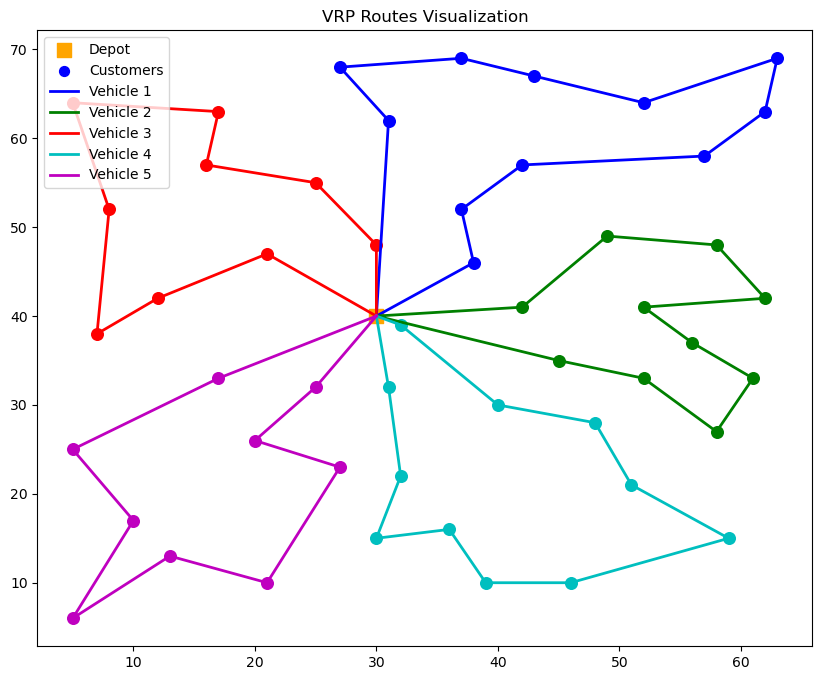


Best Solution Found by SA:
 Route 1: [1, 33, 2, 23, 21, 36, 37, 4, 29, 32, 27, 9, 1]
 -> Load: 149/160.0
 Route 2: [1, 39, 10, 31, 35, 51, 17, 22, 30, 3, 12, 1]
 -> Load: 159/160.0
 Route 3: [1, 28, 49, 24, 8, 44, 25, 26, 15, 7, 1]
 -> Load: 152/160.0
 Route 4: [1, 47, 6, 50, 11, 40, 34, 46, 16, 45, 38, 13, 1]
 -> Load: 160/160.0
 Route 5: [1, 48, 5, 18, 43, 20, 41, 42, 14, 19, 1]
 -> Load: 157/160.0
Total Cost: 524.61


In [15]:
# --- TEST ON SELECTED INSTANCE ---
runMyMetaheuristic(capacity, coordinates, demand, distances) # Data from the selected file

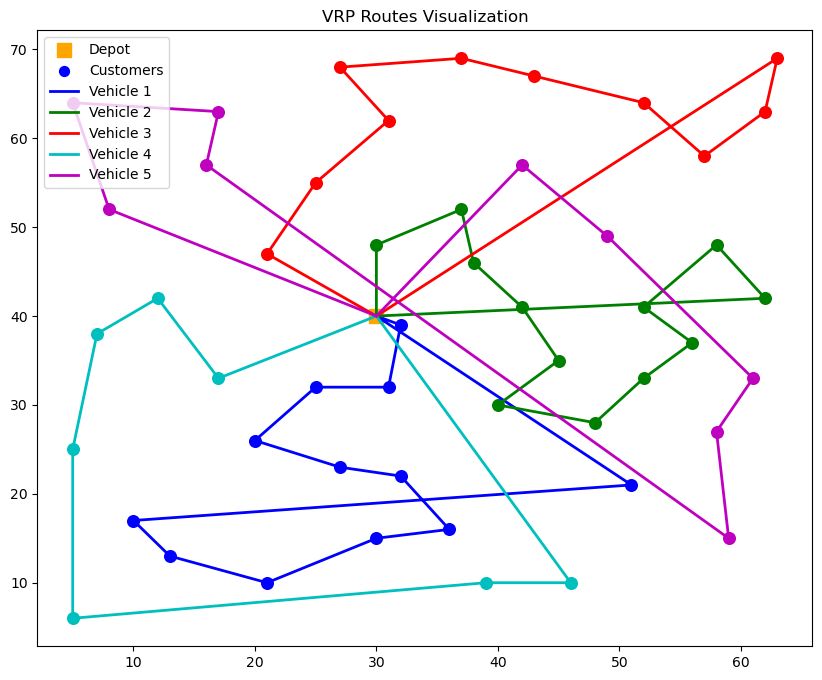

Initial solution cost (C&W): 711.4987137910165


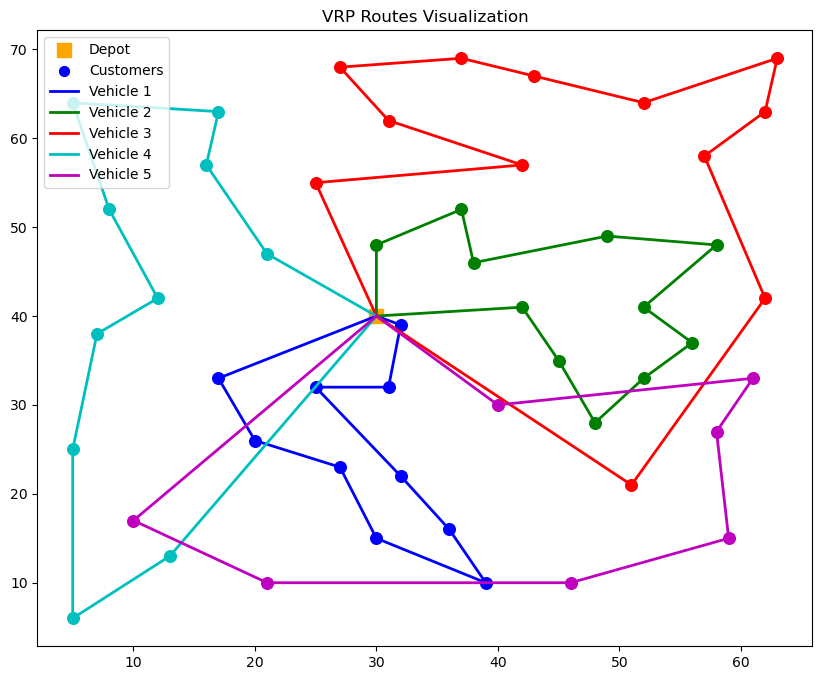

Initial solution cost (SI): 639.7730861309938


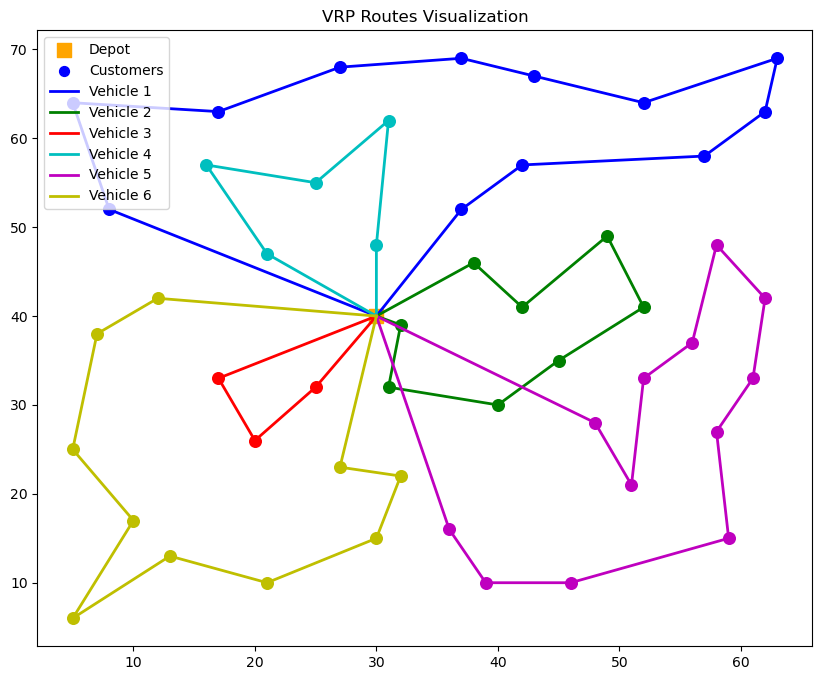

Initial solution cost (C&W): 584.6372084179408


In [16]:
# --- COMPARISON OF INITIAL SOLUTIONS ON SELECTED INSTANCE ---
solution = nearest_neighbor_vrp(distances, demand_dict=demand, capacity=capacity)
plot_vrp_graph_with_solution(coordinates, solution)
current_cost1 = total_cost(solution, distances)
print("Initial solution cost (C&W):", current_cost1)

second_solution = sequential_insertion_heuristic(distances, demand_dict=demand, capacity=capacity)
plot_vrp_graph_with_solution(coordinates, second_solution)
current_cost2 = total_cost(second_solution, distances)
print("Initial solution cost (SI):", current_cost2)

initial_solution = clarke_wright_savings(distances, demand_dict=demand, capacity=capacity)
plot_vrp_graph_with_solution(coordinates, initial_solution)
current_cost = total_cost(initial_solution, distances)
print("Initial solution cost (C&W):", current_cost)